In [1]:
#imports
import numpy as np 
import scipy.misc
import matplotlib.pyplot as plt
import sklearn 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import gc
import pandas as pd
%matplotlib inline

#import torch on collab, comment out all until import torch if not using collab 
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
  
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

#test if using GPU on collab, comment out if not have tensorflow
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Load Data

In [0]:
#if data stored locally
# x_train = np.loadtxt("train_x.csv", delimiter=",")
# y_train = np.loadtxt("train_y.csv", delimiter=",")
# x_test = np.loadtxt("test_x.csv", delimiter=",")

#if load from class web source using np
# URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"
# x_train = np.loadtxt(URL_ENDPOINT+"train_x.csv", delimiter=",")
# y_train = np.loadtxt(URL_ENDPOINT+"train_y.csv", delimiter=",")
# x_test = np.loadtxt(URL_ENDPOINT+"test_x.csv", delimiter=",")

#if previous load not work, load using pd
URL_ENDPOINT = "http://cs.mcgill.ca/~ksinha4/datasets/kaggle/"
df1 = pd.read_csv(URL_ENDPOINT+"train_x.csv", delimiter=",", header=None, dtype="uint8")
df2 = pd.read_csv(URL_ENDPOINT+"train_y.csv", delimiter=",", header=None, dtype="uint8")
#df3 = pd.read_csv(URL_ENDPOINT+"test_x.csv", delimiter=",", header=None)


In [0]:
#df to numpy for 3rd loading method
x_train = np.zeros((50000,4096), dtype="uint8")
y_train = np.zeros(50000, dtype="uint8")
x_train[:,:] = df1.as_matrix()
y_train[:] = df2.as_matrix()[:,0]

Data Manipulation Functions


In [0]:
# encode y_train data in one-hot encoding
def to_one_hot(y):
    y_train_one_hot = [[0 for i in range(10)] for i in range(len(y))]
    for i in range(len(y)):
        y_train_one_hot[i][int(y[i])] = 1

    return np.array(y_train_one_hot)
  
def from_one_hot(one_hot_data):
    y = []
    for row in one_hot_data:
        y.append(np.argmax(row))

    return y

  
#for visualization
def show_img(img):
    plt.close()
    plt.imshow(img, cmap='gray_r')
    plt.show()
#must reshape data
# x_train_reshaped = x_train.reshape(-1, 64, 64)
# y_train_reshaped = y_train.reshape(-1, 1) 
# x_test_reshaped = x_test.reshape(-1, 64, 64)


#noise reduction with squashing function 255=1 , <255=-1
#returns new np.array with dtype int8 to save on memory
def clean_data(x):
    new_data = []
    for row in x:
        new_row = []
        for pixel in row:
            if pixel == 255:
                new_row.append(1.0)
            else:
                new_row.append(-1.0)
        new_data.append(new_row)
    return np.array(new_data, dtype="int8")
#x_train = clean_data(x_train)


#shuffle data used at each epoch
def shuffle_data(x, y):
    order = np.random.permutation(x.shape[0])
    shuffled_x = x[order]
    shuffled_y = y[order]
    return shuffled_x, shuffled_y

In [0]:
#train/test split
x_train_s, x_valid_s, y_train_s, y_valid_s = train_test_split(x_train, y_train, train_size=0.8, test_size=0.2)
data = {
    "x_train": clean_data(x_train_s),
    "x_test": clean_data(x_valid_s),
    "y_train": to_one_hot(y_train_s),
    "y_test": to_one_hot(y_valid_s),
    "y_train_og": y_train_s,
    "y_test_og": y_valid_s,
}

In [6]:
#use if need to free up memory
#this deletes the original loaded data
del x_train_s, x_valid_s
del x_train, y_train
gc.collect()

319

MLP Torch Implementation using GPU

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = []
        self.num_layers = 0
    
    def add_layer(self, layer):
        self.num_layers += 1
        self.add_module(str(self.num_layers), layer)
        self.layers.append(layer)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
class View_Layer(nn.Module):
    def __init__(self, param1, param2):
        super(View_Layer, self).__init__()
        self.param1 = param1
        self.param2 = param2
        
    def forward(self, x):
        return x.view(self.param1, self.param2)
    
    
def fitGPU(mlp, x_train, y_train, x_valid, y_valid, epochs, batch=100, lr=0.001, momentum=0.9):
  
    crit = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(mlp.parameters(), lr=lr)
    
    #used to track accuracy over epochs
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    
    #max accuracy
    maxaccu = 0
    #at epoch:
    maxindex = 0
    accu = 0
    
    
    for i in range(0, epochs):
      
        #print i every 5 epoch
        if i%5 == 0:
            print(i)
            
        #shuffle data    
        X,Y = shuffle_data(x_train, y_train)
        
        #save mem
        gc.collect()
        
        
        for j in range(0, X.shape[0], batch):
           
            #create variables: x_in is float because mlp set to float to save mem
            x_in = Variable(torch.from_numpy(X[j:j+batch]).float().cuda())
            y_in = Variable(torch.from_numpy(Y[j:j+batch]).long().cuda())
            
            
            optimizer.zero_grad()
            
            #feed forward
            y_pred = mlp(x_in) 
            #calc loss
            loss = crit(y_pred, y_in)
            #back prop
            loss.backward()
            #update weights
            optimizer.step()
      
            #save mem
            del loss
            del x_in, y_in
            gc.collect()
        
        
        del X,Y
        #training acc
        train_acc[i] = get_accuracy(mlp, x_train, y_train)
        #validation acc
        accu = get_accuracy(mlp, x_valid, y_valid)
        test_acc[i] = accu
        
        #update maxacc and corresponding index(epoch)
        if accu > maxaccu:
          maxaccu = accu
          maxindex = i

    
    
    del crit, optimizer
    gc.collect()
    
    return maxaccu, maxindex, accu, train_acc, test_acc
  

def predict(mlp, x):
    return mlp(Variable(torch.from_numpy(x).float().cuda())).cpu().data.numpy()

def get_accuracy(mlp, x_valid, y_valid):
    y_pred = np.empty((len(x_valid), 10), dtype=y_valid.dtype)
    for i in range(0, len(x_valid), 100):
        y_pred[i:i+100] = predict(mlp, x_valid[i:i+100])
            
    return metrics.accuracy_score(y_valid, from_one_hot(y_pred))

K-Fold Cross Validation for Testing Multiple Values of a Hyperparameter

In [0]:
def k_foldGPU_Tune(x, y, act):
  
    gc.collect()
    
    # divide into 5 folds
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(x)
    
    #init ararays to store 5 folds, 4 values
    final_acc = np.zeros((5,4))
    max_acc = np.zeros((5,4))
    max_epoch = np.zeros((5,4))
    
    train_epoch = []
    test_epoch = []
    
    #set params
    epoch_val=50
    batch_val=500
    lr_val=.000125
    
    i = 0 

    # for each fold, train and compute accuracy
    for train_index, test_index in kf.split(x):
      
      #option to not do all 5 folds for speed
      if i < 2: 

          #create split
          new_xt, new_xv = x[train_index].astype("float"), x[test_index].astype("float")
          new_yt, new_yv = y[train_index].astype("float"), y[test_index].astype("float")


          print("Training Fold " + str(i))

          #set list of values to test
          #node_vals = np.arange(.000025, .000275, .000025)
          node_vals = [4000,3000,2000,1000]     
          #node_vals = np.logspace(-6.0, -2.0, num=5)

          #to hold learning curve for each test val in this fold
          train_KF = []
          test_KF = []

          #for each param val to be tested
          for j in range(4):

            #fit CNN to fold
            mlp = MLP()
            if act == "relu":
              mlp.add_layer(nn.Linear(4096, node_vals[j]))          
              mlp.add_layer(nn.ReLU())          
              mlp.add_layer(nn.Linear(node_vals[j], 10))
            if act == "sig":
              mlp.add_layer(nn.Linear(4096, node_vals[j]))          
              mlp.add_layer(nn.Sigmoid())          
              mlp.add_layer(nn.Linear(node_vals[j], 10))
            if act == "tanh":
              mlp.add_layer(nn.Linear(4096, node_vals[j]))          
              mlp.add_layer(nn.Tanh())          
              mlp.add_layer(nn.Linear(node_vals[j], 10))
            mlp.float()
            mlp.cuda()

            #fit
            t1, t2, t3, t4, t5 = fitGPU(mlp, new_xt, new_yt, new_xv, new_yv, epoch_val, batch=batch_val, lr=lr_val)
            print("Epoch, Batch, LR: " + str(epoch_val) + " , " + str(batch_val) + " , " + str(le_val))
            print("Results for Nodes: " + str(node_vals[j]))
            print("Max Accuracy: " + str(t1) + " at epoch: " + str(t2))
            print("Final Accuracy: " + str(t3))
            final_acc[i,j] =t3 
            max_acc[i,j] =t1 
            max_epoch[i,j] =t2 
            train_KF.append(t4)
            test_KF.append(t5)
            
            i += 1

            #save mem
            del mlp
            del t1, t2, t3, t4, t5
            gc.collect()
          
          #save mem
          del new_xt, new_yt, new_xv, new_yv
          gc.collect()
        
          #appen learning curve for each fold
          train_epoch.append(train_KF)
          test_epoch.append(test_KF)
        
        
      
    return final_acc, max_acc, max_epoch, train_epoch, test_epoch

K-Fold Cross Validation for Training With Set Hyperparam Values

In [0]:
def k_foldGPU_Test(x, y, act):
  
    
    # divide into 5 folds
    kf = KFold(n_splits=5, shuffle=True)
    kf.get_n_splits(x)
    
    final_acc = np.zeros(5)
    max_acc = np.zeros(5)
    max_epoch = np.zeros(5)
    
    #set params
    epoch_val=50
    batch_val=500
    lr_val=.000125
    
    train_epoch = []
    test_epoch = []
    
    i = 0 

    # for each fold, train and compute accuracy
    for train_index, test_index in kf.split(x):
      
        new_xt, new_xv = x[train_index].astype("float"), x[test_index].astype("float")
        new_yt, new_yv = y[train_index].astype("float"), y[test_index].astype("float")
            
        print("Training Fold " + str(i))
      
        #node_vals = np.arange(.000025, .000275, .000025)
        node_vals = 2000

        #fit MLP to fold
        mlp = MLP()
        if act == "relu":
          mlp.add_layer(nn.Linear(4096, node_vals))          
          mlp.add_layer(nn.ReLU())          
          mlp.add_layer(nn.Linear(node_vals, 10))
        if act == "sig":
          mlp.add_layer(nn.Linear(4096, node_vals))          
          mlp.add_layer(nn.Sigmoid())          
          mlp.add_layer(nn.Linear(node_vals, 10))
        if act == "tanh":
          mlp.add_layer(nn.Linear(4096, node_vals))          
          mlp.add_layer(nn.Tanh())          
          mlp.add_layer(nn.Linear(node_vals, 10))                      
        mlp.float()
        mlp.cuda()

        t1, t2, t3, t4, t5 = fitGPU(mlp, new_xt, new_yt, new_xv, new_yv, epoch_val, batch=batch_val, lr=lr_val)
        print("Epoch, Batch, LR: " + str(epoch_val) + " , " + str(batch_val) + " , " + str(le_val))
        print("Results for Node Count " + str(node_vals))
        print("Max Accuracy: " + str(t1) + " at epoch: " + str(t2))
        print("Final Accuracy: " + str(t3))
        final_acc[i] =t3 
        max_acc[i] =t1 
        max_epoch[i] =t2 
        train_epoch.append(t4)
        test_epoch.append(t5)
        
        i += 1

        #save mem
        del mlp
        del t1, t2, t3, t4, t5 
        del new_xt, new_yt, new_xv, new_yv
        gc.collect()
        
      
    return final_acc, max_acc, max_epoch, train_epoch, test_epoch

In [0]:
#need y as 0-9 not one hot
x_tr = data["x_train"].astype("float")
y_tr = data["y_train_og"].astype("float")
x_tst = data["x_test"].astype("float")
y_tst = data["y_test_og"].astype("float")

In [68]:
#free up space, if mem loss during execution some vars may not be deleted on collab

#del loss
#el mlp
#del x_in, y_in
#del y_pred
#del crit, optimizer
#del X,Y
gc.collect()

3273

In [0]:
#to tune, set vals to test in k_foldGPU_Tune then run this
r1, r2, r3, r4, r5 = k_foldGPU_Tune(x_tr, y_tr, "relu")

In [0]:
#calc mean b/w folds
rfinacc = r1.mean(0)
rmaxacc = r2.mean(0)
rmaxep = r3.mean(0)
rtrr = np.asarray(r4).mean(0)
rtst = np.asarray(r5).mean(0)

In [0]:
#graphing

xs = [i for i in range(6)]
ys = [rfinacc[i] for i in range(6)]
#ys1 = [sfinacc[i] for i in range(6)]
#ys2 = [tfinacc[i] for i in range(5)]
plt.plot(xs, ys, 'r-')
#plt.plot(xs, ys1, 'b-')
#plt.plot(xs, ys2, 'g-')
plt.xlabel('Number of Nodes')
plt.xticks(np.arange(10), ('100', '500', '1000', '2000', '3000', '5000'))
plt.ylabel('Validation Accuracy')
plt.title('Tuning Number of Nodes for ReLu Activation')
plt.legend(['ReLu'])
plt.show()

In [0]:
xs = [i for i in range(40)]
ys = [rtrr[i] for i in range(40)]
ys1 = [rtst[i] for i in range(40)]
#ys2 = [tfinacc[i] for i in range(5)]
plt.plot(xs, ys, 'r-')
plt.plot(xs, ys1, 'b-')
#plt.plot(xs, ys2, 'g-')
plt.xlabel('Epoch')
#plt.xticks(np.arange(10), np.arange(.00005, .00055, .00005))
plt.ylabel('Accuracy')
plt.title('Learning Curve ReLu 4000 Nodes')
plt.legend(['train', 'valid'])
plt.show()

In [0]:
#print result
print("ReLu Tune Node: 5foldX, batch= 2000, epoch= 50, lr=.000125 ")
print("Range: \n" + str([100,500,1000,2000,3000,5000]))
print("Final Acc: \n" + str(rfinacc))
print("Max Acc: \n" + str(rmaxacc))
print("Corresponding epoch: \n" + str(rmaxep))
print("train error over epoch for optimal Node Count \n" + str(rtrr[???]))
print("test error over epoch for optimal Node Count \n" + str(rtst[???]))
print("optimal Node Count: \n .???")

In [69]:
#del loss
#del mlp
#del x_in, y_in
#del y_pred
#del crit, optimizer
#del X,Y
gc.collect()

0

In [56]:
#to test acc on test set

mlp = MLP()
mlp.add_layer(nn.Linear(4096, 4000))          
mlp.add_layer(nn.ReLU())          
mlp.add_layer(nn.Linear(4000, 10))
mlp.float()
mlp.cuda()
t1, t2, t3, t4, t5 = fitGPU(mlp, x_tr, y_tr, x_tst, y_tst, 50, batch=500, lr=.000125)



0
5
10
15
20
25
30
35
40
45


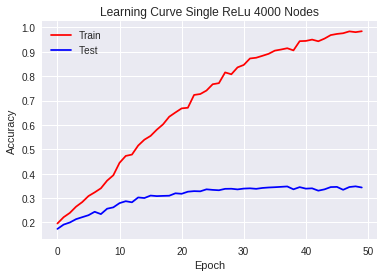

In [75]:
xs = [i for i in range(50)]
ys = [t4[i] for i in range(50)]
ys1 = [t5[i] for i in range(50)]
#ys2 = [tfinacc[i] for i in range(5)]
plt.plot(xs, ys, 'r-')
plt.plot(xs, ys1, 'b-')
#plt.plot(xs, ys2, 'g-')
plt.xlabel('Epoch')
#plt.xticks(np.arange(10), np.arange(.00005, .00055, .00005))
plt.ylabel('Accuracy')
plt.title('Learning Curve Single ReLu 4000 Nodes')
plt.legend(['Train', 'Test'])
plt.show()

In [59]:
#print result
print("ReLu Test Acc After 5foldX, batch= 500, epoch= 50, lr=.000125 ")
#print("Range: \n" + str([100,500,1000,2000,3000,5000]))
print("Final Acc: \n" + str(t3))
print("Max Acc: \n" + str(t1) + " at epoch: " + str(t2))
#print("Corresponding epoch: \n" + str())
print("train error over epoch for optimal Node Count \n" + str(t4))
print("test error over epoch for optimal Node Count \n" + str(t5))
#print("optimal Node Count: \n .???")

ReLu Test Acc After 5foldX, batch= 500, epoch= 50, lr=.000125 
Final Acc: 
0.3434
Max Acc: 
0.3481 at epoch: 48
train error over epoch for optimal Node Count 
[0.195825 0.221675 0.2393   0.264825 0.283675 0.308325 0.32345  0.340125
 0.37155  0.393525 0.44455  0.472825 0.478375 0.515325 0.53935  0.554925
 0.580375 0.60215  0.633525 0.651    0.6677   0.6703   0.7228   0.726525
 0.74085  0.766725 0.771125 0.815175 0.8075   0.835775 0.84585  0.8723
 0.875325 0.883175 0.891375 0.904475 0.908975 0.914275 0.905475 0.943225
 0.94425  0.949675 0.942825 0.953775 0.968175 0.9729   0.975775 0.9834
 0.980175 0.983925]
test error over epoch for optimal Node Count 
[0.1736 0.1913 0.2    0.2136 0.2218 0.2298 0.2439 0.2343 0.2564 0.262
 0.2793 0.2872 0.2827 0.3026 0.3002 0.3103 0.3081 0.309  0.3097 0.3196
 0.3176 0.3262 0.3285 0.3277 0.3359 0.3336 0.3321 0.3379 0.3383 0.3356
 0.3389 0.34   0.3379 0.3415 0.3434 0.3446 0.3461 0.3477 0.3359 0.3449
 0.3387 0.34   0.3304 0.3358 0.3451 0.3459 0.334  0.3453 0

In [70]:
mlp = MLP()
mlp.add_layer(nn.Linear(4096, 4000))          
mlp.add_layer(nn.ReLU())          
mlp.add_layer(nn.Linear(4000, 10))
mlp.float()
mlp.cuda()
tt1, tt2, tt3, tt4, tt5 = fitGPU(mlp, x_tr, y_tr, x_tst, y_tst, 100, batch=500, lr=.000125)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95


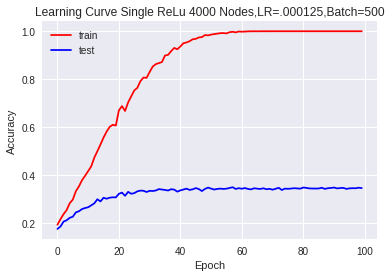

In [71]:
xs = [i for i in range(100)]
ys = [tt4[i] for i in range(100)]
ys1 = [tt5[i] for i in range(100)]
#ys2 = [tfinacc[i] for i in range(5)]
plt.plot(xs, ys, 'r-')
plt.plot(xs, ys1, 'b-')
#plt.plot(xs, ys2, 'g-')
plt.xlabel('Epoch')
#plt.xticks(np.arange(10), np.arange(.00005, .00055, .00005))
plt.ylabel('Accuracy')
plt.title('Learning Curve Single ReLu 4000 Nodes,LR=.000125,Batch=500')
plt.legend(['train', 'test'])
plt.show()

In [73]:
#print result
print("ReLu Test Acc After 5foldX, batch= 500, epoch= 100, lr=.000125 ")
#print("Range: \n" + str([100,500,1000,2000,3000,5000]))
print("Final Acc: \n" + str(tt3))
print("Max Acc: \n" + str(tt1) + " at epoch: " + str(tt2))
#print("Corresponding epoch: \n" + str())
print("train error over epoch for optimal Node Count \n" + str(tt4))
print("test error over epoch for optimal Node Count \n" + str(tt5))

ReLu Test Acc After 5foldX, batch= 500, epoch= 100, lr=.000125 
Final Acc: 
0.3449
Max Acc: 
0.3485 at epoch: 57
train error over epoch for optimal Node Count 
[0.191875 0.21505  0.236175 0.2532   0.28165  0.296675 0.331925 0.352075
 0.377925 0.3962   0.416025 0.4358   0.471975 0.499125 0.5268   0.5558
 0.5807   0.6007   0.60935  0.606125 0.6698   0.68735  0.666975 0.70275
 0.727975 0.752775 0.763625 0.791625 0.806825 0.8051   0.83     0.85235
 0.862625 0.867    0.871125 0.898825 0.901325 0.91715  0.9303   0.9248
 0.9366   0.950075 0.95315  0.958525 0.966375 0.968225 0.974075 0.975475
 0.98405  0.982775 0.9859   0.988175 0.99     0.99205  0.9924   0.990975
 0.996075 0.997775 0.995275 0.99895  0.998025 0.99865  0.999475 0.999725
 0.999875 0.9998   0.999825 1.       0.999975 0.99995  1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.    